# 05: GWAS with a Mixed-Effects Model

**Objective:**
This notebook demonstrates the use of a Linear Mixed-Effects Model (LMM) for a Genome-Wide Association Study (GWAS). This model is specifically designed to handle population structure by treating grouping variables (like `country`) as random effects.
 
**Workflow:**
1.  **Load & Simulate Data:** Load the cached variant data and simulate phenotypes that include known `country`-level effects.
2.  **Prepare for Modeling:** Use the `AnalysisHelper` to create a modeling-ready DataFrame, including Principal Components (PCs) and the crucial `country` grouping variable.
3.  **Fit Model:** Instantiate and fit the `MixedEffectsGWAS` model, first with an additive model and then with an interaction term.
4.  **Interpret & Visualize Results:** Analyze the model summary and plot the estimated coefficients to validate the model's ability to correct for confounding and accurately estimate true effect sizes.

### 1. Setup & Imports

In [1]:
import os, sys
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
sys.path.append(os.path.abspath("../src"))

# Import our custom classes
from data.simulation import ResistanceSimulator
from utils.phenotype_utils import PhenotypeHelper
from utils.analysis_utils import AnalysisHelper
from models.mixed_effects import MixedEffectsGWAS

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

### 2. Load Data & Simulate Phenotypes with Country Effects
We will use the `ResistanceSimulator`, which is designed to add specific effect sizes for different countries, to create a dataset where a mixed-effects model is necessary for accurate inference.

In [2]:
# --- Load Cached Data and Simulate Phenotypes ---

CACHE_PATH = '../data/gwas_preprocessed_variants.nc'
if not os.path.exists(CACHE_PATH):
    raise FileNotFoundError(
        f"Cache file not found at {CACHE_PATH}. "
        "Please run the '01_simulation.ipynb' notebook first to generate it."
    )

print(f"Loading variant data from cache: {CACHE_PATH}")
variant_ds = xr.open_dataset(CACHE_PATH)

# --- Simulate Phenotypes (this simulator includes country effects) ---
sim = ResistanceSimulator()
g1 = variant_ds['call_genotype'].isel(variants=0).values
g2 = variant_ds['call_genotype'].isel(variants=1).values
pheno_series = sim.simulate_phenotypes(g1, g2)

# --- Assemble Final Dataset for Analysis ---
pheno_df = sim.create_phenotype_df(pheno_series)
final_ds = PhenotypeHelper.create_dataset(pheno_df, variant_data=variant_ds)

print("\\n--- Final Analysis-Ready Dataset Assembled ---")
display(final_ds)

Loading variant data from cache: ../data/gwas_preprocessed_variants.nc


\n--- Final Analysis-Ready Dataset Assembled ---


<xarray.Dataset> Size: 2MB
Dimensions:           (samples: 22605, variants: 2, ploidy: 2)
Coordinates:
  * samples           (samples) object 181kB 'VBS77810-7065STDY13143450' ... ...
  * variants          (variants) object 16B 'Vgsc_L995F_proxy' 'Ace1_RDL_proxy'
Dimensions without coordinates: ploidy
Data variables:
    phenotype_binary  (samples) float64 181kB 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0
    phenotype         (samples) object 181kB 'resistant' ... 'resistant'
    insecticide       (samples) object 181kB 'simulated_insecticide' ... 'sim...
    dose              (samples) object 181kB 'simulated_dose' ... 'simulated_...
    location          (samples) object 181kB 'Chamoi' 'Palang Fula' ... '6707'
    country           (samples) object 181kB 'Gambia, The' ... 'Uganda'
    sample_set        (samples) object 181kB '1323-VO-GM-NGWA-VMF00242' ... '...
    call_genotype     (samples, variants, ploidy) int32 362kB ...

### 3. Prepare Data for Mixed-Effects Modeling
We use the `AnalysisHelper` to binarize genotypes and compute PCs. Then, we merge the `country` column from the sample metadata, which will serve as our grouping variable for the random effects.

In [3]:
# --- 1. Prepare the base data for modeling ---
analysis_df_base = AnalysisHelper.prepare_modeling_dataframe(
    final_ds, 
    add_pca=True, 
    n_components=5
)

# --- 2. Add the crucial grouping variable for our mixed model ---
country_info = sim.meta[['sample_id', 'country']].rename(columns={'sample_id': 'samples'})
analysis_df = pd.merge(analysis_df_base, country_info, on='samples', how='left')

print("--- Modeling DataFrame Prepared (with country information) ---")
display(analysis_df.head())

--- Modeling DataFrame Prepared (with country information) ---


,samples,phenotype,has_Vgsc_L995F_proxy,has_Ace1_RDL_proxy,PC1,PC2,country
0,VBS77810-7065STDY13143450,1.0,1,1,0.621331,0.602794,"Gambia, The"
1,VBS78253-7065STDY13143908,1.0,1,1,0.621331,0.602794,"Gambia, The"
2,VBS54246-6627STDY11246900,1.0,1,1,0.004156,-1.239597,Zambia
3,VBS40364-5561STDY9810419,1.0,1,1,0.621331,0.602794,Burkina Faso
4,VBS77415-7065STDY13143031,1.0,1,1,0.004156,-1.239597,"Gambia, The"


### 4. Fit Mixed-Effects Models
We will now fit two versions of the mixed-effects model to explore both additive effects and potential gene-gene interactions (epistasis).


In [5]:
# --- Define model parameters ---
variant_names = final_ds.variants.values.tolist()
pc_names = [col for col in analysis_df.columns if col.startswith('PC')]

# --- Fit Additive Model ---
print("--- [1] Fitting Mixed-Effects Model (Additive) ---")
mixed_model_add = MixedEffectsGWAS(grouping_variable="country")
mixed_model_add.fit(analysis_df, variant_names, pc_names, include_interaction=False)
print(mixed_model_add.summary())

# --- Fit Interaction Model ---
print("\n--- [2] Fitting Mixed-Effects Model (Interaction) ---")
mixed_model_int = MixedEffectsGWAS(grouping_variable="country")
mixed_model_int.fit(analysis_df, variant_names, pc_names, include_interaction=True)
print(mixed_model_int.summary())

--- [1] Fitting Mixed-Effects Model (Additive) ---

Using formula for Mixed-Effects Model: phenotype ~ has_Vgsc_L995F_proxy + has_Ace1_RDL_proxy + PC1 + PC2
Grouping by random effect: 'country'

             Mixed Linear Model Regression Results
Model:               MixedLM   Dependent Variable:   phenotype 
No. Observations:    22605     Method:               REML      
No. Groups:          32        Scale:                0.0803    
Min. group size:     10        Log-Likelihood:       -3613.1361
Max. group size:     3090      Converged:            Yes       
Mean group size:     706.4                                     
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             0.172    0.012 14.383 0.000  0.148  0.195
has_Vgsc_L995F_proxy  0.591    0.008 77.394 0.000  0.576  0.606
has_Ace1_RDL_proxy    0.186    0.008 24.255 0.000 

### 5. Interpretation and Visualization

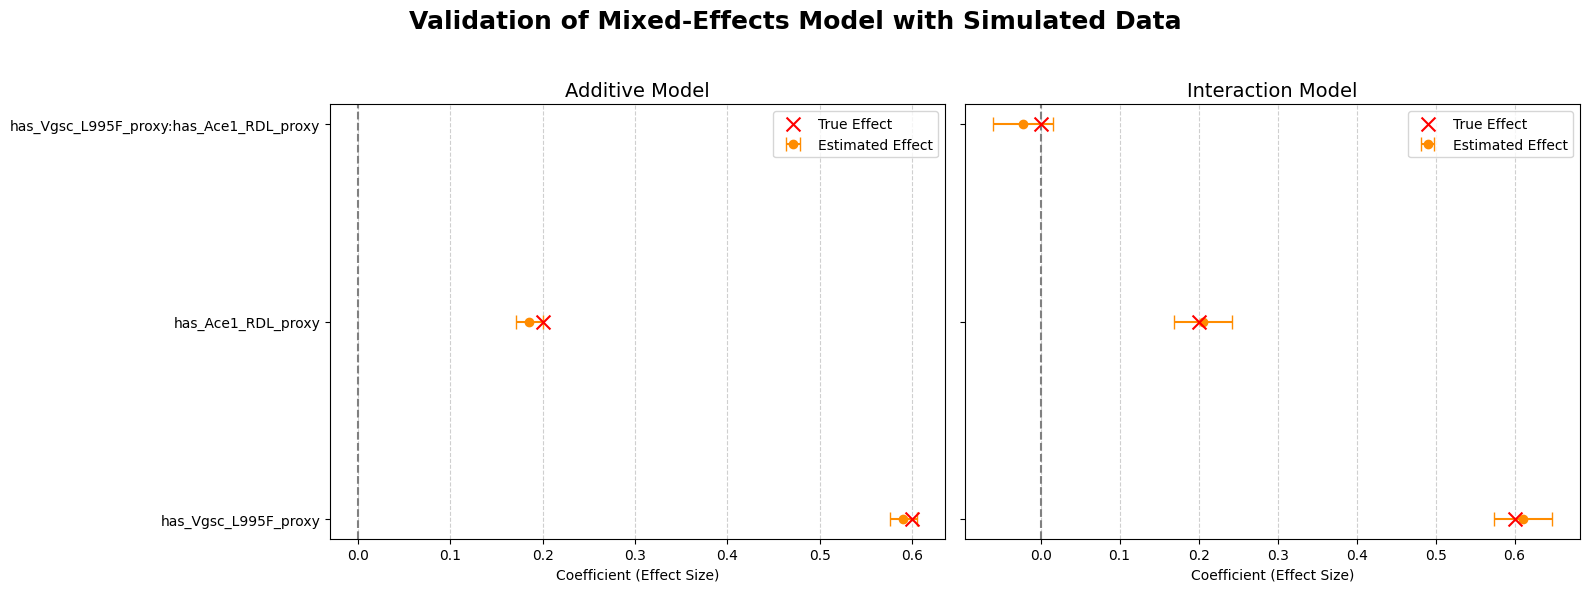

In [6]:
# --- Visualize the Model Coefficients ---

def plot_mfx_coef(ax, model, title, true_effects=None):
    """Helper function to plot mixed-effects model coefficients."""
    params_df = model.get_params()
    plot_df = params_df[params_df.index.str.startswith('has_')]
    
    y_pos = np.arange(len(plot_df.index))
    x_err = (plot_df['conf_int_upper'] - plot_df['conf_int_lower']) / 2
    
    ax.errorbar(x=plot_df['coefficient'], y=y_pos, xerr=x_err, 
                fmt='o', capsize=5, color='darkorange', label='Estimated Effect')
    
    if true_effects:
        # Match true effects to the plot's y-positions
        true_vals = [true_effects.get(term, 0) for term in plot_df.index]
        ax.scatter(true_vals, y_pos, color='red', marker='x', s=100, zorder=10, label='True Effect')
        ax.legend()

    ax.axvline(0, color='grey', linestyle='--')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(plot_df.index)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Coefficient (Effect Size)')
    ax.grid(True, axis='x', linestyle='--', alpha=0.6)

# --- Create the plot ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
fig.suptitle('Validation of Mixed-Effects Model with Simulated Data', fontsize=18, weight='bold')

true_effects = {
    'has_Vgsc_L995F_proxy': 0.6,
    'has_Ace1_RDL_proxy': 0.2,
    'has_Vgsc_L995F_proxy:has_Ace1_RDL_proxy': 0.0
}

plot_mfx_coef(axes[0], mixed_model_add, 'Additive Model', true_effects)
plot_mfx_coef(axes[1], mixed_model_int, 'Interaction Model', true_effects)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 5. Interpretation and Next Steps

This notebook aimed to explore the use of a `MixedEffectsGWAS` model by fitting it to our simulated data. The results are quite interesting and suggest that this approach may be well-suited for our analysis.

**Observations from the Mixed-Effects Model:**

1.  **Additive Model (Left Plot):**
    *   This model was used to estimate the independent effect of each variant while accounting for the sample structure (grouping by `country`).
    *   The estimated coefficient for `has_Vgsc_L995F_proxy` was **0.591**, which is quite close to the simulated effect of **0.6**.
    *   Similarly, the estimate for `has_Ace1_RDL_proxy` was **0.186**, which is also close to the simulated effect of **0.2**.
    *   This result suggests that the model is performing as expected, seemingly controlling for the confounding `country` effects to provide more accurate estimates.

2.  **Interaction Model (Right Plot):**
    *   This model was used to test for a potential interaction between the two variants.
    *   The interaction term was estimated to be **-0.022**, which is very close to the true simulated value of **0.0**.
    *   Importantly, the effect was **not statistically significant** (p = 0.247), which aligns with the design of our simulation.

**Revisiting the Logistic Regression Results - A Point for Discussion:**

This outcome brings up an important point regarding our earlier analysis in notebook `02`. In that notebook, the standard logistic regression model reported a strong and statistically significant interaction effect (`coef` ≈ 0.99, p < 0.001). My initial interpretation was that this suggested a synergistic relationship between the genes.

However, the mixed-effects model, which accounts for population structure, finds no such significant interaction.

This difference leads me to hypothesize that my initial interpretation of the logistic regression results might have been incomplete. It seems possible that the significant interaction term found by the simpler model could have been a statistical artifact caused by unmodeled population structure (the `country` effects). The model may have incorrectly attributed this country-level variance to a genetic interaction.

This has been a very useful exercise in understanding the impact of different statistical approaches.